# NBA Passing: Network Analysis and Investigation  
  
The practical question motivating this project is: does increased collaboration improve performance? Complex tasks in private business and public services are typically assigned to teams composed of individuals, where complimentary skills and expertise can augment individual contributions. This project derives insight from professional basketball where different teams develop their own strategies for team-based success at high stakes. Passing the ball is a collaborative act between teammates for the purpose of scoring. The more passes exchanged between teammates, the higher the degree of collaboration on a single possession.

In [213]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import requests
import json
import statistics
import pandoc
import time

### Getting Passing Data for Network Graphs

The main function get_passing_dataset() returns a matrix of all passes for each player on any NBA team. This function generates an empty matrix for the relationship between every player and their teammates. It then populates the adjaceny matrix with the total number of passes exchanged between players (edges between nodes), recording that sum as the weight for the tie. 

In [215]:
def get_passing_dataset(team,season):
    
    # generating a header which will allow calls to the NBA API
    # check the nba_api python wrapper for latest header if broken: https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/examples.md#endpoint-usage-example
    
    my_headers = {'Host': 'stats.nba.com',
     'Connection': 'keep-alive',
     'Accept': 'application/json, text/plain, */*',
     'x-nba-stats-token': 'true',
     'User-Agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Mobile Safari/537.36',
     'x-nba-stats-origin': 'stats',
     'Origin': 'https://www.nba.com',
     'Referer': 'https://www.nba.com/',
     'Accept-Encoding': 'gzip, deflate, br',
     'Accept-Language': 'en-US,en;q=0.9}'}  
    
    # first url pass looks at the api for the season in question

    url = 'https://stats.nba.com/stats/leaguedashptstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PerMode=PerGame&Period=0&PlayerExperience=&PlayerOrTeam=Team&PlayerPosition=&PtMeasureType=Drives&Season=' + str(season) + '&SeasonSegment=&SeasonType=Regular+Season&StarterBench=&TeamID=0&VsConference=&VsDivision=&Weight='

    # request format returns json
    
    json = requests.get(url, headers = my_headers).json()
    data = json['resultSets'][0]['rowSet']
    columns = json['resultSets'][0]['headers']

    teams = pd.DataFrame.from_records(data, columns=columns)
    team_id = teams[teams.TEAM_ABBREVIATION == team].reset_index(drop=True).TEAM_ID[0]
    team_name = teams[teams.TEAM_ABBREVIATION == team].reset_index(drop=True).TEAM_NAME[0]
    
    # second url pass looks at the api for the season and team referenced
   
    url = 'https://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=Totals&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=' + str(season) + '&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=' + str(team_id) + '&TwoWay=0&VsConference=&VsDivision=&Weight='
    
    # request format returns json
    
    json = requests.get(url, headers=my_headers).json()
    data = json['resultSets'][0]['rowSet']
    columns = json['resultSets'][0]['headers']

    df = pd.DataFrame.from_records(data, columns=columns)
    
    # generate a list of all players for each team 
    # note this includes players traded during the season
    # for example, Serge Ibaka will appear in the Clippers frame and Bucks frame
    players = df.PLAYER_ID.unique()
    # empty list to append to
    df_list = []
    # pass over the URL for every player on a team and record their passes for the regular season
    for x in players:

        url = 'https://stats.nba.com/stats/playerdashptpass?DateFrom=&DateTo=&GameSegment=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PerMode=Totals&Period=0&PlayerID=' + str(x) + '&Season=' + str(season) + '&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision='

        json = requests.get(url, headers=my_headers).json()

        data = json['resultSets'][0]['rowSet']
        columns = json['resultSets'][0]['headers']

        df_list.append(pd.DataFrame.from_records(data, columns=columns))

    df = pd.concat(df_list)

    df = df[['TEAM_ABBREVIATION','PLAYER_NAME_LAST_FIRST','PASS_TO','PASS','AST']]
    df.columns = ['tm','passer','receiver','passes','ast']
    
    # clean name 

    def fix_name(name):
        if ',' in name:
            return name.split(", ")[1][:1] + "." + name.split(", ")[0]
        else:
            return name
    df.passer = np.vectorize(fix_name)(df.passer)
    df.receiver = np.vectorize(fix_name)(df.receiver)

    df = df[df.receiver.isin(df.passer.unique())].reset_index(drop=True)
    players = df.passer.unique()
    
    # generate an adjacency matrix and populate the values based on passes 

    adf = pd.DataFrame(index=players,columns=players)

    adf.values[[np.arange(adf.shape[0])]*2] = 0
    
    for x in players:
        for y in range(0,len(players)):
            tf1 = df[(df.passer == x) & (df.receiver == adf.columns[y])].reset_index(drop=True)
            tf2 = df[(df.passer == adf.columns[y]) & (df.receiver == x)].reset_index(drop=True)
            if (tf1.shape[0] == 1) & (tf2.shape[0] == 0):
                adf.at[x,adf.columns[y]] = tf1.passes[0]
            elif (tf1.shape[0] == 0) & (tf2.shape[0] == 1):
                adf.at[x,adf.columns[y]] = tf2.passes[0]
            elif (tf1.shape[0] == 1) & (tf2.shape[0] == 1):
                adf.at[x,adf.columns[y]] = tf1.passes[0] + tf2.passes[0]
            else:
                adf.at[x,adf.columns[y]] = 0
                    
    return adf

In [216]:
bucks_matrix = get_passing_dataset('MIL','2021-22')

In [217]:
# Displaying the matrix as a savable table

def draw_as_table():
    alternating_colors = [['white'] * len(bucks_matrix.columns), ['lightgray'] * len(bucks_matrix.columns)] * len(bucks_matrix)
    alternating_colors = alternating_colors[:len(bucks_matrix)]
    fig, ax = plt.subplots(figsize= (24,8))
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=bucks_matrix.values,
                         colLabels=bucks_matrix.columns,
                         rowLabels=bucks_matrix.index,
                         rowColours=['lightblue']*len(bucks_matrix),
                         colColours=['lightblue']*len(bucks_matrix.columns),
                         cellColours=alternating_colors,
                         loc='center')
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(5)
    fig

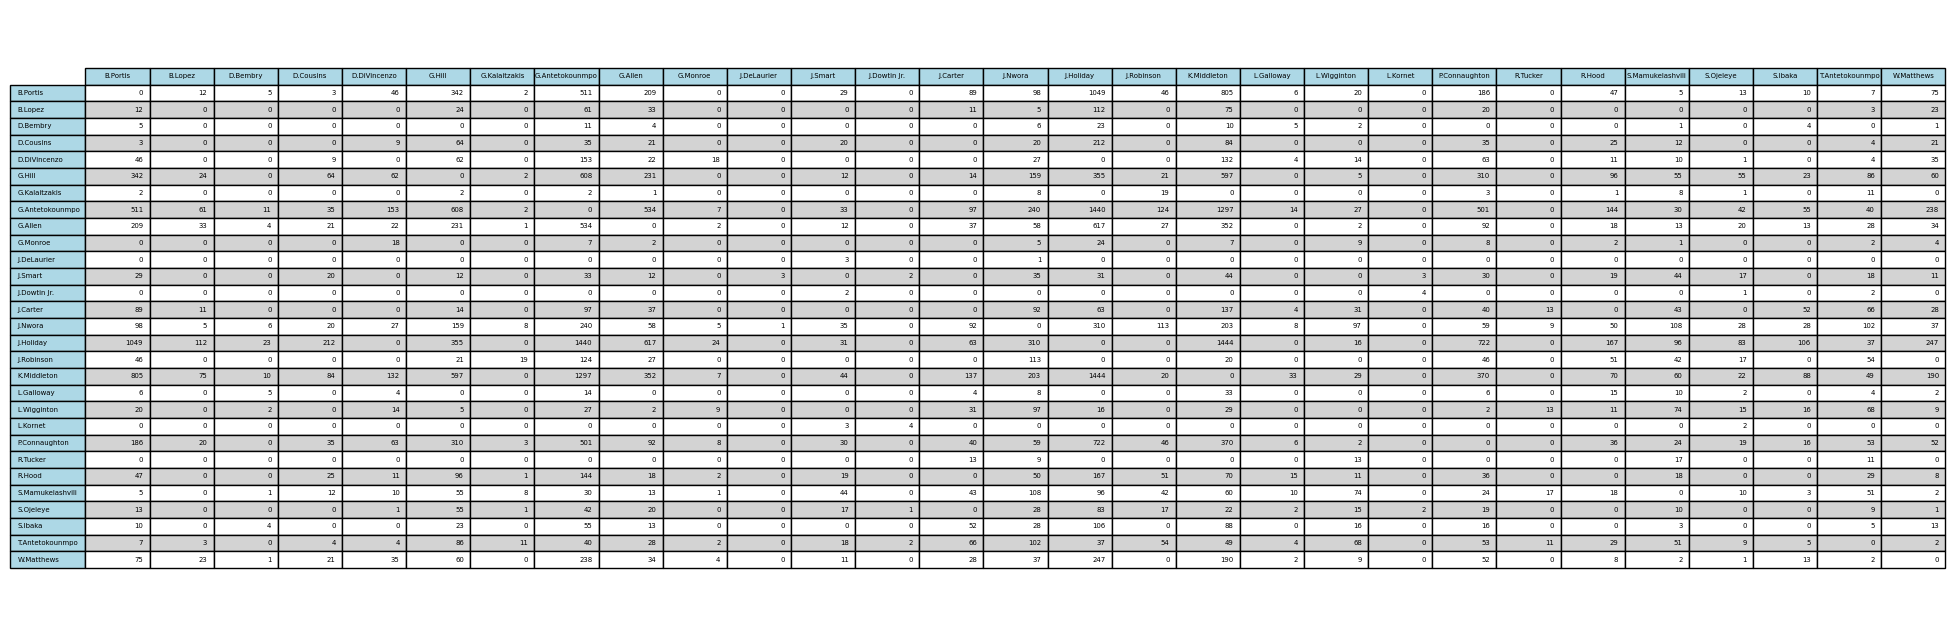

In [218]:
draw_as_table()

Text(0.5, 1.0, 'Milwaukee Bucks Passing Network: 2021-22')

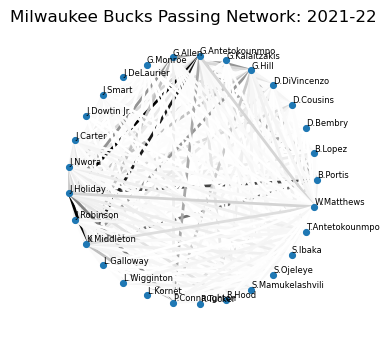

In [7]:
# Generating first draft visualization

plt.figure(figsize=(3,3))
# transform the matrix into an networkx graph as 'G'
G = nx.from_numpy_matrix(np.array(bucks_matrix.values, dtype=int), parallel_edges=True)#
    
d = dict(G.degree)
# set the weight as the pass frequency 
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    
pos = nx.circular_layout(G)
# creating new labels for nodes as players rather than numbered index of nodes    
labeldict = {}
for n in range(0,len(bucks_matrix.index)):
    labeldict[n] = bucks_matrix.index[n]

nx.draw_circular(G, labels=labeldict, 
                 with_labels=True,
                 font_size=6,
                 horizontalalignment='left',
                 verticalalignment='bottom',
                 clip_on=False,
                 nodelist=d.keys(), 
                 node_size=10, linewidths=2, 
                 edgelist=edges, edge_color=weights, 
                 width=2, edge_cmap=plt.cm.binary)
plt.title('Milwaukee Bucks Passing Network: 2021-22')


#### Gephi Layout  
  
The following graphic is the final rendering using the software Gephi.    
    
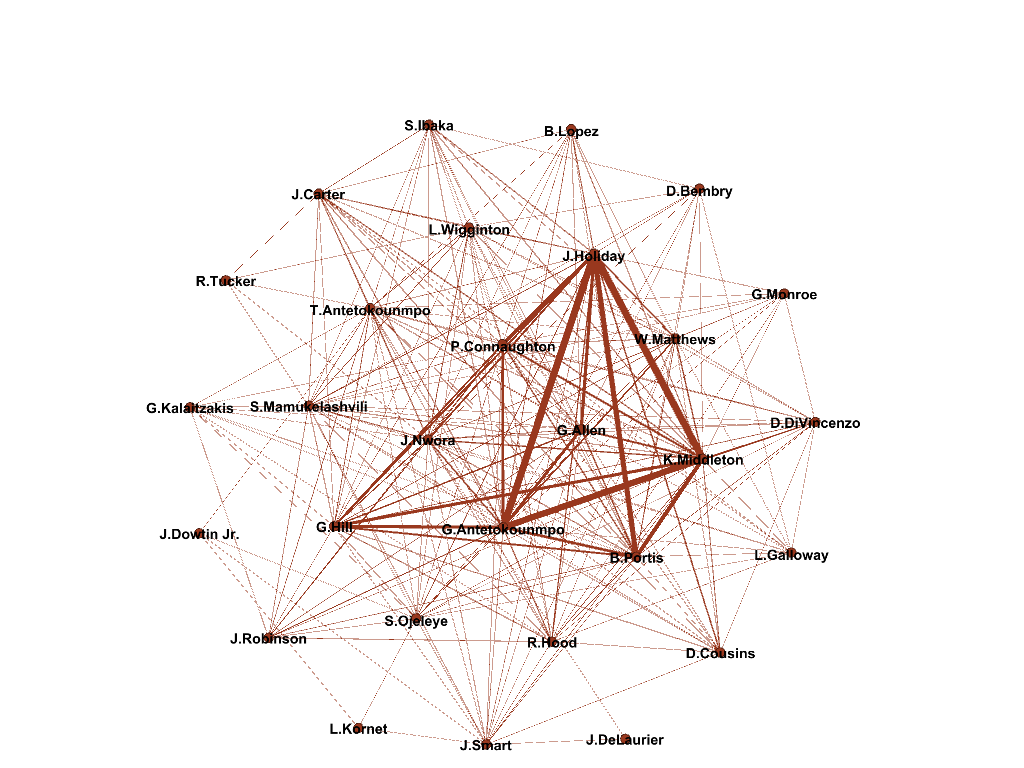

In [8]:
# creating a dictionary of official abbrevaitions, copied from nba.com
nba_teams_dict = nba_teams = {
    'Atlanta Hawks': 'ATL',
    'Boston Celtics': 'BOS',
    'Brooklyn Nets': 'BKN',
    'Charlotte Hornets': 'CHA',
    'Chicago Bulls': 'CHI',
    'Cleveland Cavaliers': 'CLE',
    'Dallas Mavericks': 'DAL',
    'Denver Nuggets': 'DEN',
    'Detroit Pistons': 'DET',
    'Golden State Warriors': 'GSW',
    'Houston Rockets': 'HOU',
    'Indiana Pacers': 'IND',
    'Los Angeles Clippers': 'LAC',
    'Los Angeles Lakers': 'LAL',
    'Memphis Grizzlies': 'MEM',
    'Miami Heat': 'MIA',
    'Milwaukee Bucks': 'MIL',
    'Minnesota Timberwolves': 'MIN',
    'New Orleans Pelicans': 'NOP',
    'New York Knicks': 'NYK',
    'Oklahoma City Thunder': 'OKC',
    'Orlando Magic': 'ORL',
    'Philadelphia 76ers': 'PHI',
    'Phoenix Suns': 'PHX',
    'Portland Trail Blazers': 'POR',
    'Sacramento Kings': 'SAC',
    'San Antonio Spurs': 'SAS',
    'Toronto Raptors': 'TOR',
    'Utah Jazz': 'UTA',
    'Washington Wizards': 'WAS'
}
#storing abbreviations as a list to loop over later
nba_abbreviations = list(nba_teams_dict.values())

In [224]:
def create_matrices():
    matrices = {}
    # create a dictionary and make each key ###_matrix for the official abbreviation
    for abbreviation in nba_abbreviations:
        
        # putting in a one second delay between loops to avoid timeouts
        time.sleep(1)
        
        # create a new variable as a key in the matrix and store the results of the passing dataset there
        matrices[f"{abbreviation}_matrix"] = get_passing_dataset(abbreviation, "2021-22")
    return matrices

In [ ]:
%%time
# Note this process is resource intensive and loops over team. 
# Estimated Run time 25 mins
create_matrices()

#alternatively run fpr a single team:
#ATL_matrix = get_passing_dataset('ATL','2021-22')

### Pulling in End of Season Statistics 

In [10]:
from nba_api.stats.endpoints import leaguestandings

# Pulling all end of season summary statistics excluding playoffs. 
season_end = leaguestandings.LeagueStandings(league_id='00', season ='2021-22', season_type = 'Regular Season')
nbassn2021_22 = season_end.get_data_frames()[0]

nbassn2021_22.head(3)


,LeagueID,SeasonID,TeamID,TeamCity,TeamName,Conference,ConferenceRecord,PlayoffRank,ClinchIndicator,Division,...,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,PreAS,PostAS
0,00,22021,1610612748,Miami,Heat,East,35-17,1,- e,Southeast,...,None,None,None,None,None,5-1,8-7,10-5,38-21,15-8
1,00,22021,1610612756,Phoenix,Suns,West,39-13,1,- w,Pacific,...,None,None,None,None,None,2-3,16-0,9-5,48-10,16-8
2,00,22021,1610612738,Boston,Celtics,East,33-19,2,- a,Atlantic,...,None,None,None,None,None,2-4,9-6,6-9,34-26,17-5


### Finding total passes and assists for every team 

In [11]:
from nba_api.stats.endpoints import TeamDashPtPass

# creating a new dataframe to count the total number of passes by using a groupby statement
def pass_totaler():
    team_passes = TeamDashPtPass(team_id='', season='2021-22', per_mode_simple='Totals')
    
    passes_df = team_passes.get_data_frames()[0]
    passes_df = passes_df[['TEAM_ID', 'PASS']]
    passes_df = passes_df.groupby('TEAM_ID')['PASS'].sum().reset_index()
    
    return passes_df

In [12]:
nbassn2021_22_passes = pass_totaler()
nbassn2021_22_passes = nbassn2021_22_passes.rename(columns={'TEAM_ID': 'TeamID', 'PASS': 'TotalPasses'})
nbassn2021_22_passes.head(3)

,TeamID,TotalPasses
0,1610612737,21329
1,1610612738,23723
2,1610612739,24352


In [13]:
# repeating the process for assists, again using groupby and sum to find the total for each team
def ast_totaler():
    team_asts = TeamDashPtPass(team_id='', season='2021-22', per_mode_simple='Totals')
    
    asts_df = team_asts.get_data_frames()[0]
    asts_df = asts_df[['TEAM_ID', 'AST']]
    asts_df = asts_df.groupby('TEAM_ID')['AST'].sum().reset_index()
    
    return asts_df

In [14]:
nbassn2021_22_asts = ast_totaler()
nbassn2021_22_asts = nbassn2021_22_asts.rename(columns={'TEAM_ID': 'TeamID', 'AST': 'TotalAsts'})
nbassn2021_22_asts.head(3)

,TeamID,TotalAsts
0,1610612737,2016
1,1610612738,2012
2,1610612739,2058


In [15]:
# merging each dataframe to add the new values as columns to the appropriate team 

nbassn2021_22 = pd.merge(nbassn2021_22, nbassn2021_22_passes, on='TeamID')

In [16]:
nbassn2021_22 = pd.merge(nbassn2021_22, nbassn2021_22_asts, on='TeamID')

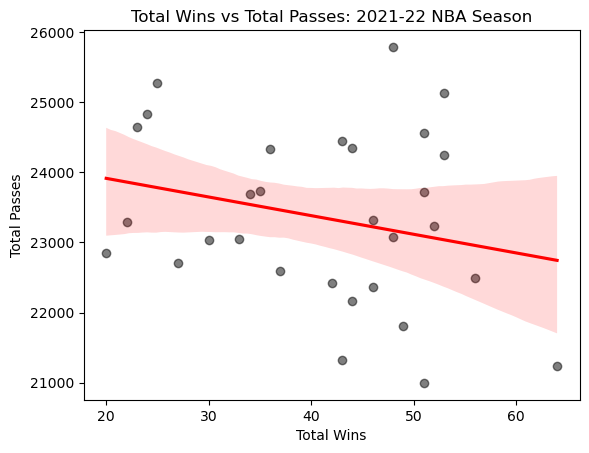

PearsonRResult(statistic=-0.2483647957468334, pvalue=0.1857042039334141)

In [17]:
# visualizing the relationship between wins and passes

import seaborn as sns
import scipy.stats as stats

sns.regplot(x='WINS',
    y='TotalPasses',
    data = nbassn2021_22,
           scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red"}) 
plt.xlabel('Total Wins')
plt.ylabel('Total Passes')
plt.title('Total Wins vs Total Passes: 2021-22 NBA Season')
plt.show()

stats.pearsonr(nbassn2021_22['WINS'], nbassn2021_22['TotalPasses'])

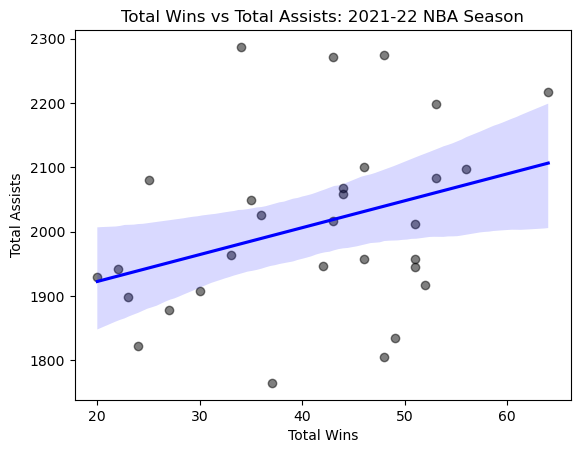

PearsonRResult(statistic=0.34444707560891197, pvalue=0.06232885123684439)

In [18]:
# visualizing the relationship between wins and assists 

p = sns.regplot(x='WINS',
    y='TotalAsts',
    data = nbassn2021_22,
           scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "blue"}) 
plt.xlabel('Total Wins')
plt.ylabel('Total Assists')
plt.title('Total Wins vs Total Assists: 2021-22 NBA Season')
plt.show()

stats.pearsonr(nbassn2021_22['WINS'], nbassn2021_22['TotalAsts'])

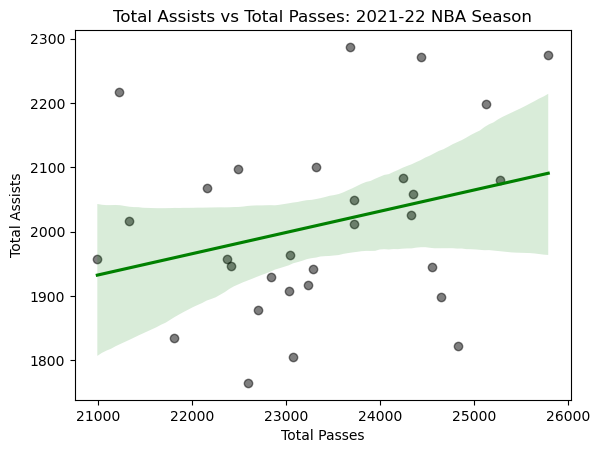

PearsonRResult(statistic=0.2914631291983138, pvalue=0.11811726703291855)

In [19]:
# visualizing the relationship between assists and passes 

p = sns.regplot(x='TotalPasses',
    y='TotalAsts',
    data = nbassn2021_22,
           scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "green"}) 
plt.xlabel('Total Passes')
plt.ylabel('Total Assists')
plt.title('Total Assists vs Total Passes: 2021-22 NBA Season')
plt.show()

stats.pearsonr(nbassn2021_22['TotalPasses'], nbassn2021_22['TotalAsts'])

#### Pre-season Power Ranking by Conference

In order to detirmine whether a team out-performed expectations, this section creates a measure of over performance. This is done by evaluating each team's preseason power ranking and their final finishing place before the playoffs started. The power rankings for each conference are taken from ESPN which also uses its own expert pannel as well as Caesars Sportsbook odds.

Found at https://www.espn.com/nba/story/_/id/32399420/nba-preview-2021-22-power-rankings-projections-breakout-stars-storylines-all-30-teams

Eastern Conference:

- Milwaukee Bucks
- Brooklyn Nets
- Miami Heat
- Philadelphia 76ers
- Atlanta Hawks
- Boston Celtics
- Charlotte Hornets
- Chicago Bulls
- Indiana Pacers
- New York Knicks
- Toronto Raptors
- Washington Wizards
- Cleveland Cavaliers
- Detroit Pistons
- Orlando Magic

Western Conference:

- Los Angeles Lakers
- Phoenix Suns
- Utah Jazz
- Denver Nuggets
- LA Clippers
- Golden State Warriors
- Dallas Mavericks
- Portland Trail Blazers
- Memphis Grizzlies
- Minnesota Timberwolves
- New Orleans Pelicans
- Sacramento Kings
- San Antonio Spurs
- Oklahoma City Thunder
- Houston Rockets  


In [20]:
east_teams = [
    "Bucks",
    "Nets",
    "Heat",
    "76ers",
    "Hawks",
    "Celtics",
    "Hornets",
    "Bulls",
    "Pacers",
    "Knicks",
    "Raptors",
    "Wizards",
    "Cavaliers",
    "Pistons",
    "Magic"]

east_rankings = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

west_teams = [
    "Lakers",
    "Suns",
    "Jazz",
    "Nuggets",
    "Clippers",
    "Warriors",
    "Mavericks",
    "Trail Blazers",
    "Grizzlies",
    "Timberwolves",
    "Pelicans",
    "Kings",
    "Spurs",
    "Thunder",
    "Rockets"]
west_rankings = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

df_east = pd.DataFrame(list(zip(east_teams, east_rankings)), columns=['TeamName', 'PreSeasonRanking'])
df_west = pd.DataFrame(list(zip(west_teams, west_rankings)), columns=['TeamName', 'PreSeasonRanking'])

rankings_df = pd.concat([df_east, df_west], ignore_index=True)
rankings_df.head(3)

,TeamName,PreSeasonRanking
0,Bucks,1
1,Nets,2
2,Heat,3


In [21]:
nbassn2021_22 = pd.merge(nbassn2021_22, rankings_df, on='TeamName')

### Outperforming Expectations

The RankingDifferential Column is a measure of how much a team out-peformed expecations. This is found by substracting the pre-season power ranking by the final finishing place for each team in each conference. For example, being ranked number one, the favorite to become champion, but finishing in fourth place would result in a score of -3. I refer to this as an improvement benchmark. 

In [22]:
nbassn2021_22['RankingDifferential'] = nbassn2021_22['PreSeasonRanking'] - nbassn2021_22['PlayoffRank'] 

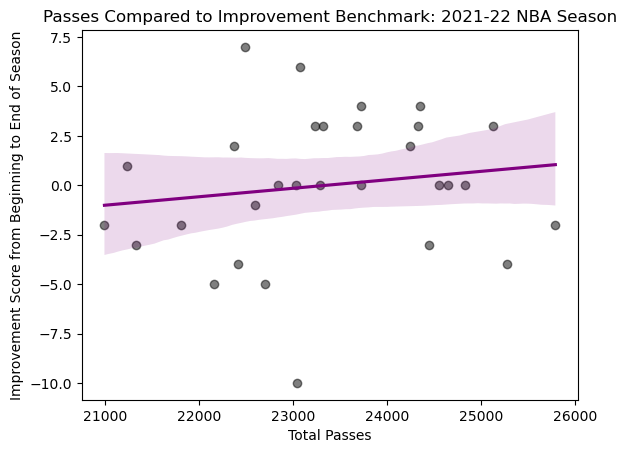

PearsonRResult(statistic=0.14590117547365952, pvalue=0.4417106846957914)

In [23]:
# visualizing the relationship between passes and scores for outperforming expectations  

p = sns.regplot(x='TotalPasses',
    y='RankingDifferential',
    data = nbassn2021_22,
           scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "purple"}) 
plt.xlabel('Total Passes')
plt.ylabel('Improvement Score from Beginning to End of Season')
plt.title('Passes Compared to Improvement Benchmark: 2021-22 NBA Season')
plt.show()

stats.pearsonr(nbassn2021_22['TotalPasses'], nbassn2021_22['RankingDifferential'])

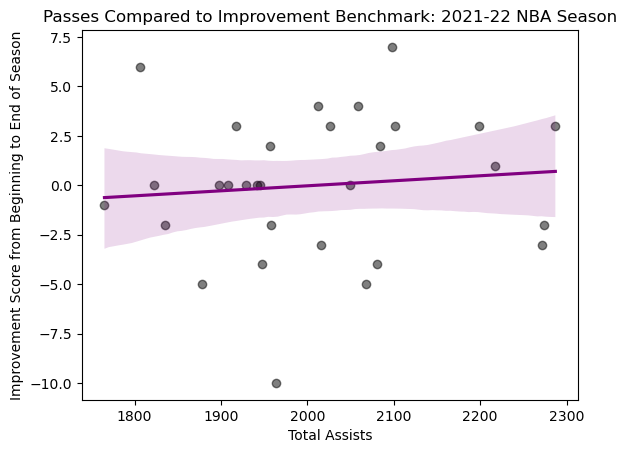

PearsonRResult(statistic=0.09790926756685847, pvalue=0.6067461055251364)

In [24]:
# visualizing the relationship between assosts and scores for outperforming expectations  

p = sns.regplot(x='TotalAsts',
    y='RankingDifferential',
    data = nbassn2021_22,
           scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "purple"}) 
plt.xlabel('Total Assists')
plt.ylabel('Improvement Score from Beginning to End of Season')
plt.title('Passes Compared to Improvement Benchmark: 2021-22 NBA Season')
plt.show()

stats.pearsonr(nbassn2021_22['TotalAsts'], nbassn2021_22['RankingDifferential'])

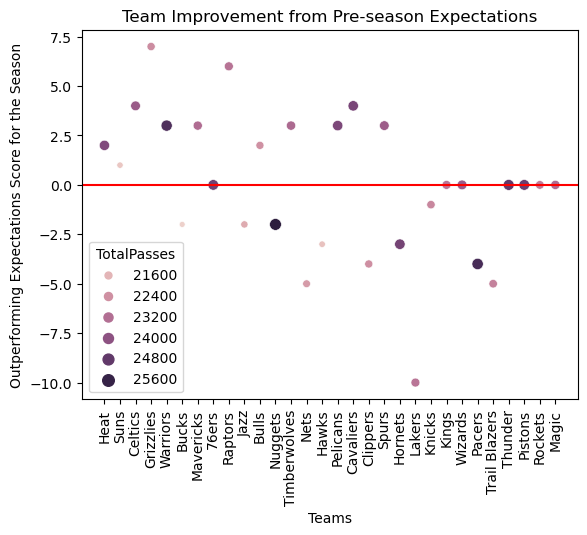

In [25]:
# visualizing the relationship between passes and scores for outperforming expectations  

sns.scatterplot(data=nbassn2021_22, 
                x="TeamName", y="RankingDifferential", size="TotalPasses", hue='TotalPasses')
plt.xlabel('Teams')
plt.ylabel('Outperforming Expectations Score for the Season')
plt.title('Team Improvement from Pre-season Expectations')
plt.axhline(0.0, color='red')
plt.xticks(rotation='vertical')
plt.show()

#### Passes Per Assist

This metric measures the average number of passes made by a team's players before an assist is recorded. It can provide insights into the team's style of play and ball movement, indicating how well the team is passing the ball and creating scoring opportunities for teammates.

A high passes-per-assist ratio could suggest that the team engages in more ball movement and passing, involving multiple players in the creation of scoring opportunities. This measure will be low for Teams which play a lot of "Iso" where in one player isolates an opposing defensemen gaurding them and attempts to score alone as other players draw opposing defensemen away from the isolation tactic.

In [26]:
# Finding the Assists Divided by Passes
nbassn2021_22['PassesPerAssist'] = nbassn2021_22['TotalPasses'] / nbassn2021_22['TotalAsts'] 

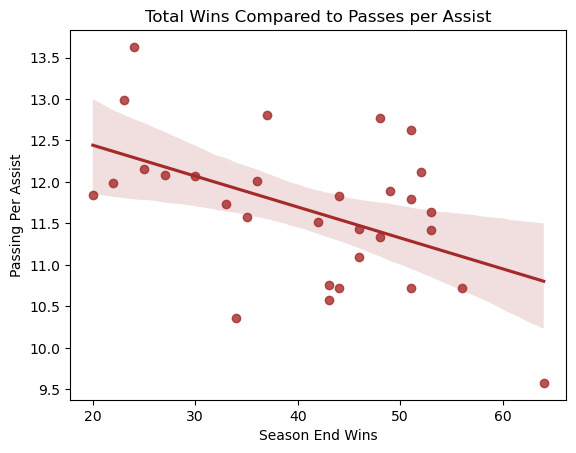

PearsonRResult(statistic=-0.500536217860549, pvalue=0.004846874299290819)

In [27]:
# visualizing the relationship between wins and passes per assist 

sns.regplot(data=nbassn2021_22, 
                x="WINS", y="PassesPerAssist", color='brown')
plt.xlabel('Season End Wins')
plt.ylabel('Passing Per Assist')
plt.title('Total Wins Compared to Passes per Assist')
plt.show()

stats.pearsonr(nbassn2021_22['WINS'], nbassn2021_22['PassesPerAssist'])

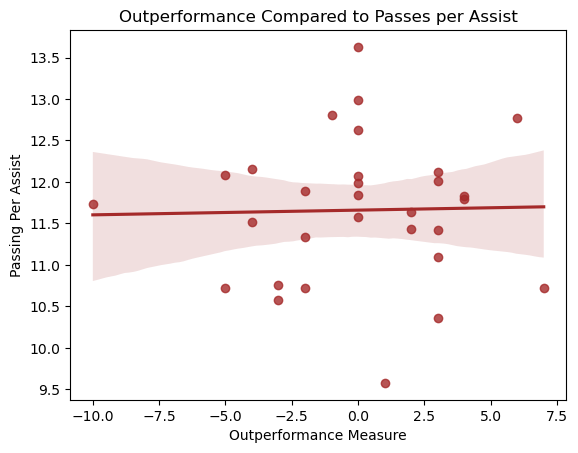

PearsonRResult(statistic=0.02405998541634209, pvalue=0.8995733189610797)

In [28]:
# visualizing the relationship between outperformance and passes per assist 

sns.regplot(data=nbassn2021_22, 
                x="RankingDifferential", y="PassesPerAssist", color='brown')
plt.xlabel('Outperformance Measure')
plt.ylabel('Passing Per Assist')
plt.title('Outperformance Compared to Passes per Assist')
plt.show()

stats.pearsonr(nbassn2021_22['RankingDifferential'], nbassn2021_22['PassesPerAssist'])

# Super Star Effect

Professional basketball has a reputation for being "star-driven." Elite players have a great deal of autonomy in their play style as well as in their bargining posistions with franchies relative to other sports such as football. This is the result of a variety of factors, e.g. the CBA (Collective Bargaining Agreement between the players association - the NBPA - and the NBA sets out the terms and conditions of employment for all professional basketball players).  

This metric tallies the number of elite stars on each team.  

The most selective measure (other than MVP) is first-team All-NBA which are the five best players at their respective positions. This is followed by second-team All-NBA and third-team All-NBA. In total this is 15 players who are recognized as the best of the league. 

AllNbaHonors counts the number of players on each NBA team who earned All-NBA honors (first team, second team, or third team) over the past three years.

In [200]:
# Checking the format for every player 

from nba_api.stats.endpoints import playerawards

jokic = playerawards.PlayerAwards(player_id = '203999').get_data_frames()[0] # Testing on Nikola Jokic 
seasons = ['2021-22', '2020-21', '2019-20'] 
season_awards = jokic[jokic['SEASON'].isin(seasons)]
all_nba_awards = season_awards[season_awards['DESCRIPTION'].str.contains('All-NBA')]
all_nba_awards['TEAM_NAME'] = all_nba_awards['TEAM'].str.split().str[-1]
all_nba_awards.head(5)

C:\Users\brand\AppData\Local\Temp\ipykernel_19740\3555343363.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_nba_awards['TEAM_NAME'] = all_nba_awards['TEAM'].str.split().str[-1]


,PERSON_ID,FIRST_NAME,LAST_NAME,TEAM,DESCRIPTION,ALL_NBA_TEAM_NUMBER,SEASON,MONTH,WEEK,CONFERENCE,TYPE,SUBTYPE1,SUBTYPE2,SUBTYPE3,TEAM_NAME
1,203999,Nikola,Jokic,Denver Nuggets,All-NBA,2,2019-20,None,None,West,Award,Kia Motors,KIANT,None,Nuggets
2,203999,Nikola,Jokic,Denver Nuggets,All-NBA,1,2020-21,None,None,West,Award,Kia Motors,KIANT,None,Nuggets
21,203999,Nikola,Jokic,Denver Nuggets,All-NBA,1,2021-22,None,None,West,Award,Kia Motors,KIANT,None,Nuggets


In [201]:
from nba_api.stats.endpoints import commonallplayers, playerawards

# Retrieve player IDs and team information for the 2021-22 season
players = commonallplayers.CommonAllPlayers(is_only_current_season=1).get_data_frames()[0]

# Setting a dictionary for each team to add to 
team_honors = {}
for team in players.TEAM_NAME.unique():
    team_honors[team] = []
    
# Loop through each player and retrieve their award information
for i in players.PERSON_ID:
    
    # Add a delay of 1 second before making the request;
    # will need approximately 8 minutes to run 
    time.sleep(1)
    
    try:
        awards = playerawards.PlayerAwards(player_id=i).get_data_frames()[0]
        awards['TEAM_NAME'] = awards['TEAM'].str.split().str[-1]
        seasons = ['2021-22', '2020-21', '2019-20'] 
        season_awards = awards[awards['SEASON'].isin(seasons)]
        mask = players['PERSON_ID'] == i
        player_info = players.loc[mask]
        plays_for = player_info['TEAM_NAME'].iloc[0]
        all_nba_awards = season_awards[season_awards['DESCRIPTION'].str.contains('All-NBA')]
        superstar_score = len(all_nba_awards[all_nba_awards['ALL_NBA_TEAM_NUMBER'] != 'None'])

    except:
        continue
        
    # Append the number of All-NBA honors for each player to their respective team's list
    team_honors[plays_for].append(superstar_score)
    
# Calculate the sum of All-NBA honors for each team
for team in team_honors:
    team_honors[team] = sum(team_honors[team])
    
    # Create a dataframe with the team names and their total number of All-NBA honors for the season
all_nba_df = pd.DataFrame.from_dict(team_honors, orient='index', columns=['AllNbaHonors'])
all_nba_df.index.name = 'TeamName'

In [202]:
all_nba_df.reset_index(inplace=True)

In [203]:
# Adding AllNbaHonors to the Dataframe
nbassn2021_22 = pd.merge(nbassn2021_22, all_nba_df, on='TeamName')

In [204]:
nbassn2021_22.head(5)

,LeagueID,SeasonID,TeamID,TeamCity,TeamName,Conference,ConferenceRecord,PlayoffRank,ClinchIndicator,Division,...,Nov,Dec,PreAS,PostAS,TotalPasses,TotalAsts,PreSeasonRanking,RankingDifferential,PassesPerAssist,AllNbaHonors
0,00,22021,1610612748,Miami,Heat,East,35-17,1,- e,Southeast,...,8-7,10-5,38-21,15-8,24247,2084,3,2,11.634837,2
1,00,22021,1610612756,Phoenix,Suns,West,39-13,1,- w,Pacific,...,16-0,9-5,48-10,16-8,21231,2217,2,1,9.576455,5
2,00,22021,1610612738,Boston,Celtics,East,33-19,2,- a,Atlantic,...,9-6,6-9,34-26,17-5,23723,2012,6,4,11.790755,2
3,00,22021,1610612763,Memphis,Grizzlies,West,36-16,2,- sw,Southwest,...,8-7,12-4,41-19,15-7,22494,2098,9,7,10.721640,1
4,00,22021,1610612744,Golden State,Warriors,West,33-19,3,- x,Pacific,...,13-2,9-4,42-17,11-12,25127,2199,6,3,11.426558,2


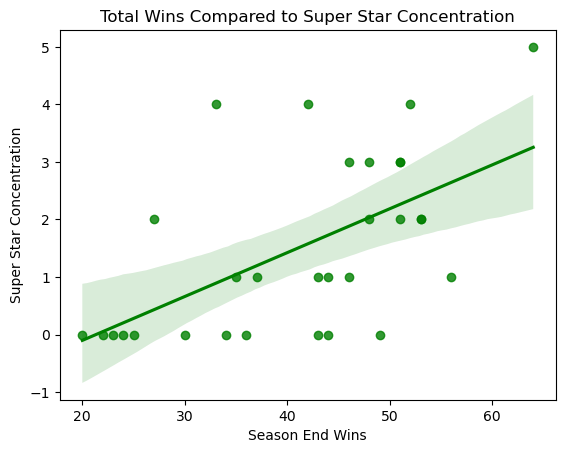

PearsonRResult(statistic=0.5783942433370752, pvalue=0.0008140822480751044)

In [207]:
# visualizing the relationship between wins and super star effect

sns.regplot(data=nbassn2021_22, 
                x="WINS", y="AllNbaHonors", color='green')
plt.xlabel('Season End Wins')
plt.ylabel('Super Star Concentration')
plt.title('Total Wins Compared to Super Star Concentration')
plt.show()

stats.pearsonr(nbassn2021_22['WINS'], nbassn2021_22['AllNbaHonors'])

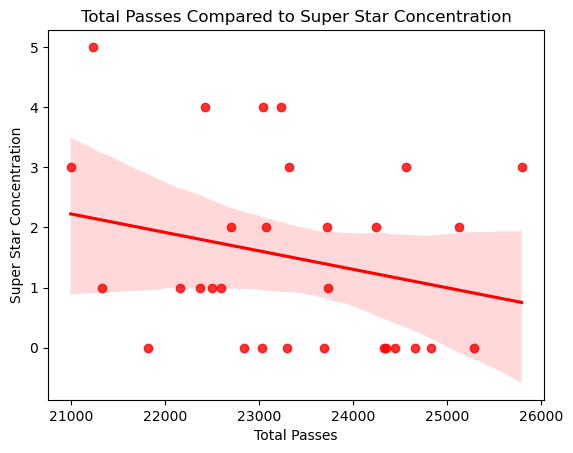

PearsonRResult(statistic=-0.24928547698933556, pvalue=0.1840257607905582)

In [209]:
# visualizing the relationship between passes and super star effect

sns.regplot(data=nbassn2021_22, 
                x="TotalPasses", y="AllNbaHonors", color='red')
plt.xlabel('Total Passes')
plt.ylabel('Super Star Concentration')
plt.title('Total Passes Compared to Super Star Concentration')
plt.show()

stats.pearsonr(nbassn2021_22['TotalPasses'], nbassn2021_22['AllNbaHonors'])

# Network Analysis

## Analyses:  

This section utilizing network science techniques to measure team and player performance.  

The metrics that follow are:  
   
    1. Unweighted and Weighted Network Centrality by Player  
    2. Unweighted and Weighted Clustering Coefficent for the Team  
    3. Gini Coefficient of the Team's Distribution  
    4. Other Connectivity Measures



In [219]:
# Network Centrality by Player

labeldict = {}
for n in range(0,len(bucks_matrix.index)):
    labeldict[n] = bucks_matrix.index[n]

# Degree Centrality
G = nx.from_numpy_matrix(np.array(bucks_matrix.values, dtype=int), parallel_edges=True)

# Setting labels to return names
nx.set_node_attributes(G, labeldict, 'label')

# Calculate the degree centrality for each node
degree_centrality = nx.degree_centrality(G)

# Sorting values
sorted_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

centrality_dict = {}
# Print the degree centrality for each node
for node, centrality in sorted_nodes:
    label = G.nodes[node]['label']
    print("Node:", label, ' - ', "Degree Centrality:", centrality)
    centrality_dict[label] = centrality


Node: J.Nwora  -  Degree Centrality: 0.9285714285714285
Node: T.Antetokounmpo  -  Degree Centrality: 0.8928571428571428
Node: G.Antetokounmpo  -  Degree Centrality: 0.8571428571428571
Node: S.Mamukelashvili  -  Degree Centrality: 0.8571428571428571
Node: B.Portis  -  Degree Centrality: 0.8214285714285714
Node: G.Allen  -  Degree Centrality: 0.8214285714285714
Node: K.Middleton  -  Degree Centrality: 0.8214285714285714
Node: P.Connaughton  -  Degree Centrality: 0.8214285714285714
Node: W.Matthews  -  Degree Centrality: 0.7857142857142857
Node: G.Hill  -  Degree Centrality: 0.75
Node: J.Holiday  -  Degree Centrality: 0.7142857142857142
Node: L.Wigginton  -  Degree Centrality: 0.6785714285714285
Node: R.Hood  -  Degree Centrality: 0.6785714285714285
Node: S.Ojeleye  -  Degree Centrality: 0.6785714285714285
Node: J.Smart  -  Degree Centrality: 0.6071428571428571
Node: D.DiVincenzo  -  Degree Centrality: 0.5714285714285714
Node: J.Carter  -  Degree Centrality: 0.5714285714285714
Node: D.Cou

Jordan Nwora and the Antetokounmpo brothers have the highest centrality scores. High centrality score would indicate that a particular player has a high number passing partners, suggesting that they are more involved in the passing network and have more connections compared to other players in the team. This indicates that the player is heavily involved in the passing dynamics of the team, either as a frequent passer or as a player who receives passes from many teammates. Such a player may be considered a key facilitator in the team's passing network, contributing to ball movement and team coordination.
The distribution of centrality scores shows how each player fits within the network relative to their connections in passing.

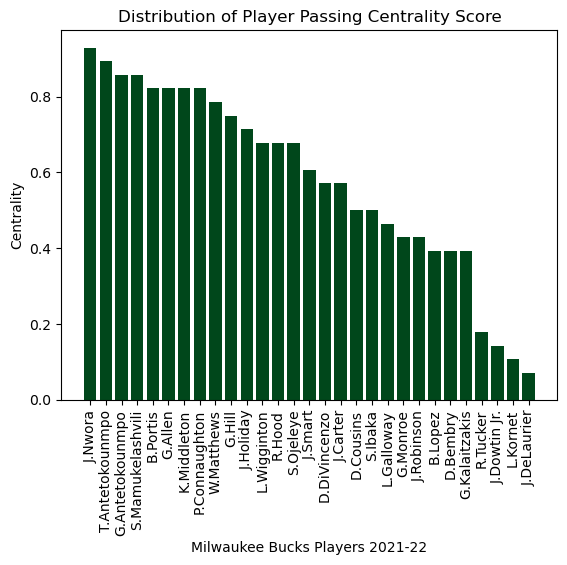

In [220]:
# Distribution of Centrality Scores
cent_df = pd.DataFrame.from_dict(centrality_dict, orient='index', columns=['Score']).reset_index()

# Create a bar chart using Matplotlib
plt.subplots()
plt.bar(cent_df ['index'], cent_df['Score'], color='#00471B') #bucks jersey hex color
plt.xlabel('Milwaukee Bucks Players 2021-22')
plt.ylabel('Centrality')
plt.title('Distribution of Player Passing Centrality Score')
plt.xticks(rotation='vertical')
plt.show()

In [221]:
# Weighted Degree Centrality 

weighted_degree_centrality = {}
for node in G.nodes():
    label = G.nodes[node]['label']
    weighted_degree = sum(G[node][neighbor]['weight'] for neighbor in G.neighbors(node))
    weighted_degree_centrality[label] = weighted_degree

weighted_df = pd.DataFrame.from_dict(weighted_degree_centrality, orient='index', columns=['Score']).reset_index()
weighted_df.rename(columns={'index':'Player', 'Score':'Weighted Centrality'},inplace=True)
weighted_df.sort_values(by='Weighted Centrality',ascending=False, inplace=True)

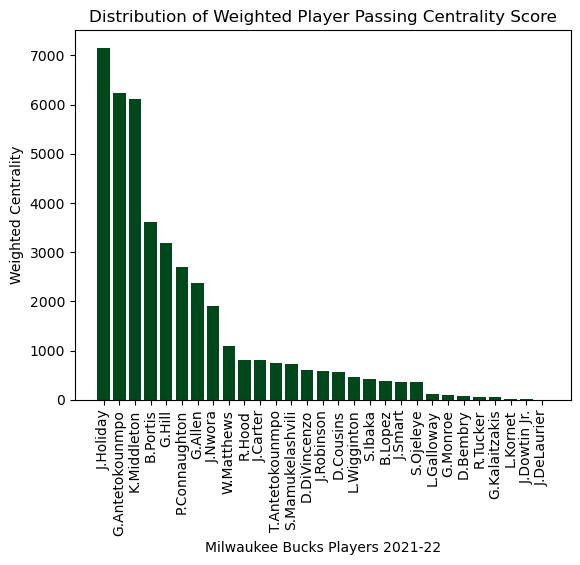

In [223]:
# Create a bar chart using Matplotlib
fig, ax = plt.subplots()
ax.bar(weighted_df['Player'], weighted_df['Weighted Centrality'], color='#00471B')
plt.xlabel('Milwaukee Bucks Players 2021-22')
plt.ylabel('Weighted Centrality')
plt.title('Distribution of Weighted Player Passing Centrality Score')
plt.xticks(rotation='vertical')
plt.show()


When accounting for weight, Jrue Holiday, Giannis Antetokounmpo, and Kris Middleton have much higher centrality scores. This is a more accurate representation of passing <b>frequency</b>. Holiday is the point gaurd; Giannas and Middleton are the best players on the Bucks, illustrating the distribution of the ball on the network. 

In [224]:
# Clustering Coefficent for Team

# Compute the clustering coefficient
clustering_coefficient = nx.average_clustering(G)

print("Clustering Coefficient: ", clustering_coefficient)

Clustering Coefficient:  0.8372790913714878


The clustering coefficient is a measure of how tightly connected the neighbors of a node are in a graph. It quantifies the degree to which nodes in a graph tend to form clusters or local communities.The clustering coefficient can take on values between 0 and 1, where 0 indicates that nodes in the graph do not form clusters and are not tightly connected, and 1 indicates that all neighbors of a node are connected to each other, forming a complete subgraph.  
  
The Bucks have a 0.8372790913714878 coefficient

In [227]:
clustering_coeffs_weights = nx.clustering(G, weight='weight')
team_weighted_clustering_coeff = sum(clustering_coeffs_weights.values()) 
print("Weighted Clustering Coefficient: ", team_weighted_clustering_coeff)

Weighted Clustering Coefficient:  0.8215129376698626


Taking into consideration the weight as the number of passes between nodes (players), the coefficient drops to 0.8215129376698626 for the Bucks.  
  
A higher value indicates a higher degree of clustering, suggesting that the team's players tend to pass the ball to each other in a more cohesive and interconnected manner.  

In weighted networks or directed networks, it is possible to have a clustering coefficient greater than 1. This can occur when a node has multiple connections to the same neighbor, and the weights of these connections are summed up to compute the clustering coefficient.

In [244]:
# Gini coefficient 

bucks_centrality_values = np.array(list(centrality_dict.values()))
bucks_weightedcentrality_values = np.array(list(weighted_degree_centrality.values()))

def gini(arr):
    sorted_arr = np.sort(arr)
    n = arr.shape[0]
    coef = (2 * np.sum(sorted_arr * np.arange(1, n+1))) / (n * np.sum(sorted_arr) ) - (n+1)/n
    return coef

gini_coefficient = gini(bucks_centrality_values)
gini_coefficient_w_weight = gini(bucks_weightedcentrality_values)

print("Gini Coefficient: ", gini_coefficient)
print("Gini Coefficient of weighted data: ", gini_coefficient_w_weight)

Gini Coefficient:  0.23670368205727632
Gini Coefficient of weighted data:  0.6442265834874048


The Gini coefficient is a measure of inequality often used to quantify the distribution of wealth or income within a population. It ranges from 0 (perfect equality, where everyone has the same amount of wealth/income) to 1 (perfect inequality, where one person has all the wealth/income and everyone else has none). Here, I apply the same concept to the distribtuion of passing measures. A team with a very low Gini coefficient passes the ball frequently with many players involved in the offense. A high coefficient indicates the team passes has a less interconnected passing strategy. 

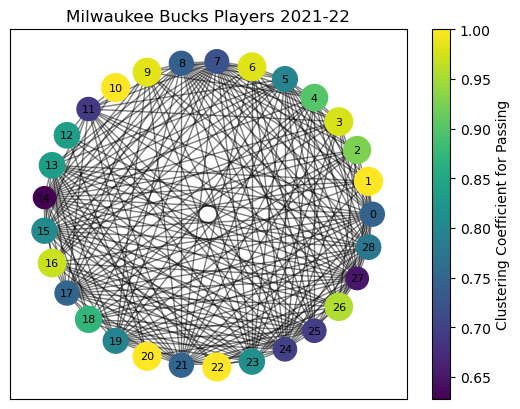

In [34]:
clustering_coefficients = nx.clustering(G)
pos = nx.circular_layout(G)
# Draw the graph with node color representing the clustering coefficient
node_colors = [clustering_coefficients[i] for i in G.nodes()]
# Scale node size based on clustering coefficient
node_size = [400 * clustering_coefficients[i] for i in G.nodes()]  

nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap='viridis', node_size=node_size)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, labels=None, font_size=8)
plt.title("Milwaukee Bucks Players 2021-22")

# Create a colorbar
plt.colorbar(nodes, label="Clustering Coefficient for Passing")

# Show the plot
plt.show()

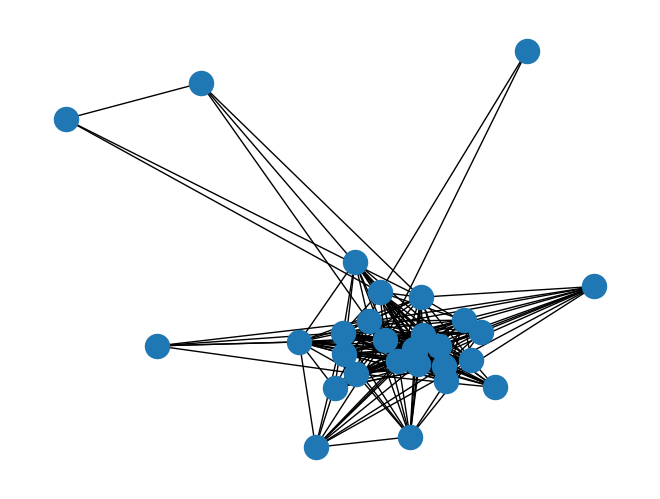

In [35]:
# Network Connectivity Sub Graph

connected_components = nx.connected_components(G)

# Drawing each connected component separately
for component in connected_components:
    nx.draw(G.subgraph(component), label = G.nodes[node]['label'])
    plt.show()

A connected component is a subgraph of a graph where all nodes are reachable from any other node within the component. The function returns a generator object that produces sets of nodes representing the connected components of the graph G. Each set of nodes represents a separate connected component in the graph. This visual is intended to the separate groups or clusters of nodes in the graph and understand the overall structure of the network.

In [36]:
# Network Betweenness

# Compute betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)


# Sorting values
sorted_between = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

betweenness_dict = {}
# Print the betweenness for each node
for node, betweenness in sorted_between:
    label = G.nodes[node]['label']
    print("Node:", label, ' - ', "Node Betweenness:", betweenness)
    betweenness_dict[label] = betweenness

Node: J.Nwora  -  Node Betweenness: 0.08237708108872667
Node: T.Antetokounmpo  -  Node Betweenness: 0.06358377162902422
Node: J.Smart  -  Node Betweenness: 0.061446531879578666
Node: S.Ojeleye  -  Node Betweenness: 0.056840824291563216
Node: S.Mamukelashvili  -  Node Betweenness: 0.03112543003548831
Node: G.Antetokounmpo  -  Node Betweenness: 0.022059620771266355
Node: G.Allen  -  Node Betweenness: 0.019168787324877354
Node: B.Portis  -  Node Betweenness: 0.01843961496872087
Node: K.Middleton  -  Node Betweenness: 0.017925402549746547
Node: P.Connaughton  -  Node Betweenness: 0.017342897013765363
Node: W.Matthews  -  Node Betweenness: 0.014474224098568095
Node: L.Wigginton  -  Node Betweenness: 0.014276812699733594
Node: G.Hill  -  Node Betweenness: 0.011456690333907888
Node: J.Holiday  -  Node Betweenness: 0.010779307903651895
Node: J.Carter  -  Node Betweenness: 0.00846977096977097
Node: R.Hood  -  Node Betweenness: 0.008181545086306991
Node: D.DiVincenzo  -  Node Betweenness: 0.0027

Network betweenness is a measure used in network analysis to quantify the importance of nodes or edges in a network based on their potential to act as intermediaries or "bridges" between other nodes or groups of nodes. It is a measure of how often a node or edge lies on the shortest paths between pairs of nodes in a network. This measure utilizes the Brandes' algorithm.   

In [37]:
# Eigenvector Centrality

# Compute eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G)

# Sorting values
sorted_eigen = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

eigen_dict = {}
# Print the betweenness for each node
for node, eigen in sorted_eigen:
    label = G.nodes[node]['label']
    print("Node:", label, ' - ', "Eigenvector Centrality:", eigen)
    eigen_dict[label] = eigen

Node: J.Nwora  -  Eigenvector Centrality: 0.2486703457796739
Node: G.Antetokounmpo  -  Eigenvector Centrality: 0.2446200748483081
Node: T.Antetokounmpo  -  Eigenvector Centrality: 0.24284237513021253
Node: S.Mamukelashvili  -  Eigenvector Centrality: 0.2408568070515594
Node: P.Connaughton  -  Eigenvector Centrality: 0.2382452281018513
Node: K.Middleton  -  Eigenvector Centrality: 0.23812819777641478
Node: B.Portis  -  Eigenvector Centrality: 0.2374013764639545
Node: G.Allen  -  Eigenvector Centrality: 0.23720071313477703
Node: W.Matthews  -  Eigenvector Centrality: 0.2310372962631954
Node: G.Hill  -  Eigenvector Centrality: 0.22360716800396666
Node: J.Holiday  -  Eigenvector Centrality: 0.2145063903152166
Node: R.Hood  -  Eigenvector Centrality: 0.20497700928877666
Node: L.Wigginton  -  Eigenvector Centrality: 0.2029290790935423
Node: S.Ojeleye  -  Eigenvector Centrality: 0.1914292356243305
Node: D.DiVincenzo  -  Eigenvector Centrality: 0.18166599987673981
Node: J.Carter  -  Eigenvecto

Eigenvector centrality is a measure used in network analysis to quantify the importance or centrality of nodes in a network based on their connections to other highly central nodes. It is a measure of the relative influence or prominence of a node within a network, taking into account both the number and quality of its connections. Nodes with higher eigenvector centrality scores are considered more central within the network, as they have more influential connections to other central nodes

## Generating all coefficients for each team

The following two functions are written to either pull the coefficients for all teams based on an API call or a local pull of the data from download. 

In [257]:
def get_network_stats():
    # generate a list of matrix names 
    matrix_names = []
    for abbreviation in nba_abbreviations:
        matrix_names.append(abbreviation + "_matrix")
    network_stats=[]
    for i in matrix_names:
        
        labeldict = {}
        for n in range(0,len(i.index)):
            labeldict[n] = i.index[n]
        
        G = nx.from_numpy_matrix(np.array(i.values(), dtype=int), parallel_edges=True)
        nx.set_node_attributes(G, labeldict, 'label')
        
        degree_centrality = nx.degree_centrality(G)
        sorted_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
        centrality_dict = {}
        for node, centrality in sorted_nodes:
            label = G.nodes[node]['label']
            centrality_dict[label] = centrality
        weighted_degree_centrality = {}
        for node in G.nodes():
            label = G.nodes[node]['label']
            weighted_degree = sum(G[node][neighbor]['weight'] for neighbor in G.neighbors(node))
            weighted_degree_centrality[label] = weighted_degree
        centrality_values = np.array(list(centrality_dict.values()))
        weightedcentrality_values = np.array(list(weighted_degree_centrality.values()))
        
        gini_coefficient = gini(centrality_values)
        gini_coefficient_w_weight = gini(weightedcentrality_values)
        clustering_coefficient = nx.average_clustering(G)
        clustering_coeffs_weights = nx.clustering(G, weight='weight')
        team_weighted_clustering_coeff = sum(clustering_coeffs_weights.values()) 
        entry = list(i, clustering_coefficient,team_weighted_clustering_coeff,gini_coefficient,gini_coefficient_w_weight)
        network_stats.append(entry)
    return network_stats 



##### Alternative local data load

In [245]:
import os
directory = # INSERT LOCAL FILE PATH #
files = os.listdir(directory)
csv_files = [file for file in files if file.endswith('.csv')]
all_matrices_dict = {}
for file in csv_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path)
    df.set_index('Unnamed: 0', inplace=True)
    key = file.split('.')[0]
    all_matrices_dict[key] = df

In [258]:
def get_network_stats_locally():
    network_stats=[]
    for key, df in all_matrices_dict.items():
        
        labeldict = {}
        for n in range(0,len(df.index)):
            labeldict[n] = df.index[n]
        
        G = nx.from_numpy_matrix(np.array(df.values, dtype=int), parallel_edges=True)
        nx.set_node_attributes(G, labeldict, 'label')
        
        degree_centrality = nx.degree_centrality(G)
        sorted_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
        centrality_dict = {}
        for node, centrality in sorted_nodes:
            label = G.nodes[node]['label']
            centrality_dict[label] = centrality
        weighted_degree_centrality = {}
        for node in G.nodes():
            label = G.nodes[node]['label']
            weighted_degree = sum(G[node][neighbor]['weight'] for neighbor in G.neighbors(node))
            weighted_degree_centrality[label] = weighted_degree
        
        centrality_values = np.array(list(centrality_dict.values()))
        weightedcentrality_values = np.array(list(weighted_degree_centrality.values()))
        
        gini_coefficient = gini(centrality_values)
        gini_coefficient_w_weight = gini(weightedcentrality_values)
        clustering_coefficient = nx.average_clustering(G)
        clustering_coeffs_weights = nx.clustering(G, weight='weight')
        team_weighted_clustering_coeff = sum(clustering_coeffs_weights.values()) 
        
        entry = list([key, clustering_coefficient, team_weighted_clustering_coeff,gini_coefficient,gini_coefficient_w_weight])
        network_stats.append(entry)
    return network_stats 

In [260]:
def clean_df(df):
    # take the list of lists representing each team and convert them to a dataframe 
    coeff_df = pd.DataFrame(df)
    coeff_df= coeff_df.rename(columns={0: 'TeamName', 1: 'ClusteringCoeff', 2: 'WeightedClusteringCoeff', 
                                      3: 'GiniCoeff', 4: 'GiniCoeffWeighted'})
    coeff_df['TeamName'] = coeff_df['TeamName'].str.split('_').str[0].str.title()
    
    return coeff_df 

In [261]:
# pull the data in and run it over the cleaning function 
df = get_network_stats_locally()
coeff_df = clean_df(df)
nbassn2021_22 = pd.merge(nbassn2021_22, coeff_df, on='TeamName')

In [264]:
max_cluster_coeff = nbassn2021_22['ClusteringCoeff'].idxmax()
min_cluster_coeff = nbassn2021_22['ClusteringCoeff'].idxmin()
max_weighted_coeff = nbassn2021_22['WeightedClusteringCoeff'].idxmax()
min_weighted_coeff = nbassn2021_22['WeightedClusteringCoeff'].idxmin()
max_gini_coeff = nbassn2021_22['GiniCoeff'].idxmax()
min_gini_coeff = nbassn2021_22['GiniCoeff'].idxmin()
max_gini_coeff_weight = nbassn2021_22['GiniCoeffWeighted'].idxmax()
min_gini_coeff_weight = nbassn2021_22['GiniCoeffWeighted'].idxmin()

print('The Team with the Highest Cluster Coefficient is the:', nbassn2021_22.loc[max_cluster_coeff, 'TeamName'])
print('The Team with the Lowest Cluster Coefficient is the:', nbassn2021_22.loc[min_cluster_coeff, 'TeamName'])
print('\n')
print('The Team with the Highest Weighted Clustering Score is the:', nbassn2021_22.loc[max_weighted_coeff, 'TeamName'])
print('The Team with the Lowest Weighted Clustering Score is the:', nbassn2021_22.loc[min_weighted_coeff, 'TeamName'])
print('\n')
print('The Team with the Highest Gini Coefficient is the:', nbassn2021_22.loc[max_gini_coeff, 'TeamName'])
print('The Team with the Lowest Gini Coefficient is the:', nbassn2021_22.loc[min_gini_coeff, 'TeamName'])
print('\n')
print('The Team with the Highest Gini Coefficient controlling for weight is the:', nbassn2021_22.loc[max_gini_coeff_weight, 'TeamName'])
print('The Team with the Lowest Gini Coefficient controlling for weight is the:', nbassn2021_22.loc[min_gini_coeff_weight, 'TeamName'])

The Team with the Highest Cluster Coefficient is the: Warriors
The Team with the Lowest Cluster Coefficient is the: Celtics


The Team with the Highest Weighted Clustering Score is the: Warriors
The Team with the Lowest Weighted Clustering Score is the: Nuggets


The Team with the Highest Gini Coefficient is the: Celtics
The Team with the Lowest Gini Coefficient is the: Warriors


The Team with the Highest Gini Coefficient controlling for weight is the: Celtics
The Team with the Lowest Gini Coefficient controlling for weight is the: Warriors


Note that the Golden State Warriors (Western Conference champions) defeated the Boston Celtics (Eastern Conference champions) in six games to win the 2021-22 NBA Finals. Here, the Warriors hold the highest score, representing two different styles of basketball. 

### Testing Coefficent Scores against Success (Wins)

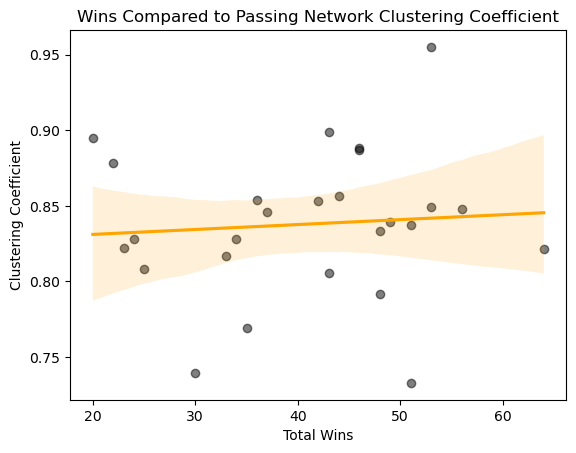

PearsonRResult(statistic=0.07877762438726998, pvalue=0.7020693603268962)

In [145]:
# visualizing the relationship between winning and network clustering 

sns.regplot(x='WINS',
    y='ClusteringCoeff',
    data = nbassn2021_22,
           scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "orange"}) 
plt.xlabel('Total Wins')
plt.ylabel('Clustering Coefficient')
plt.title('Wins Compared to Passing Network Clustering Coefficient')
plt.show()

stats.pearsonr(nbassn2021_22['WINS'], nbassn2021_22['ClusteringCoeff'])

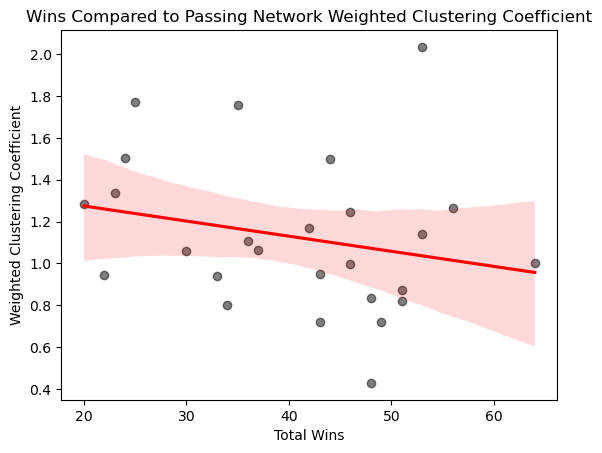

PearsonRResult(statistic=-0.23233082062024868, pvalue=0.25340825030165937)

In [265]:
# visualizing the relationship between winning and weighted network clustering 

sns.regplot(x='WINS',
    y='WeightedClusteringCoeff',
    data = nbassn2021_22,
           scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red"}) 
plt.xlabel('Total Wins')
plt.ylabel('Weighted Clustering Coefficient')
plt.title('Wins Compared to Passing Network Weighted Clustering Coefficient')
plt.show()

stats.pearsonr(nbassn2021_22['WINS'], nbassn2021_22['WeightedClusteringCoeff'])

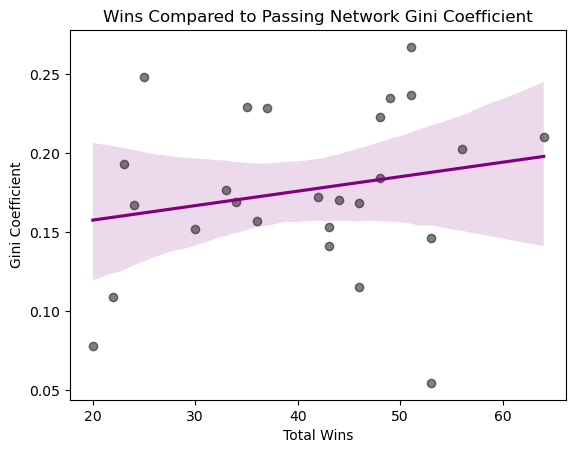

PearsonRResult(statistic=0.20793347279507504, pvalue=0.308056596199043)

In [269]:
# Visualizing the relationship between winning and the Gini coefficient

sns.regplot(x='WINS',
    y='GiniCoeff',
    data = nbassn2021_22,
           scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "purple"}) 
plt.xlabel('Total Wins')
plt.ylabel('Gini Coefficient')
plt.title('Wins Compared to Passing Network Gini Coefficient')
plt.show()

stats.pearsonr(nbassn2021_22['WINS'], nbassn2021_22['GiniCoeff'])

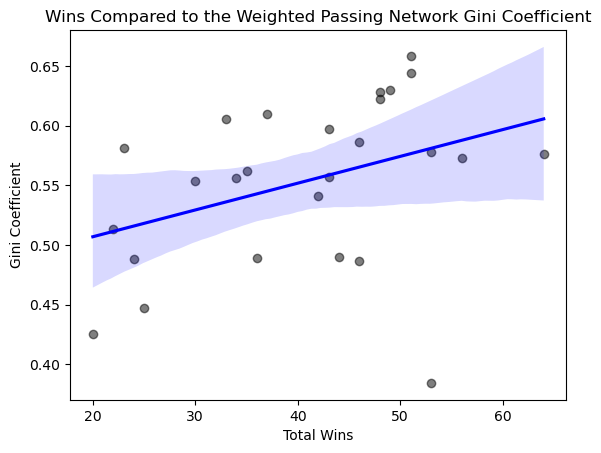

PearsonRResult(statistic=0.3780388534700823, pvalue=0.05688707708339619)

In [272]:
# Visualizing the relationship between winning and the Gini coefficient for the weighted passing network

sns.regplot(x='WINS',
    y='GiniCoeffWeighted',
    data = nbassn2021_22,
           scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "blue"}) 
plt.xlabel('Total Wins')
plt.ylabel('Gini Coefficient')
plt.title('Wins Compared to the Weighted Passing Network Gini Coefficient')
plt.show()

stats.pearsonr(nbassn2021_22['WINS'], nbassn2021_22['GiniCoeffWeighted'])

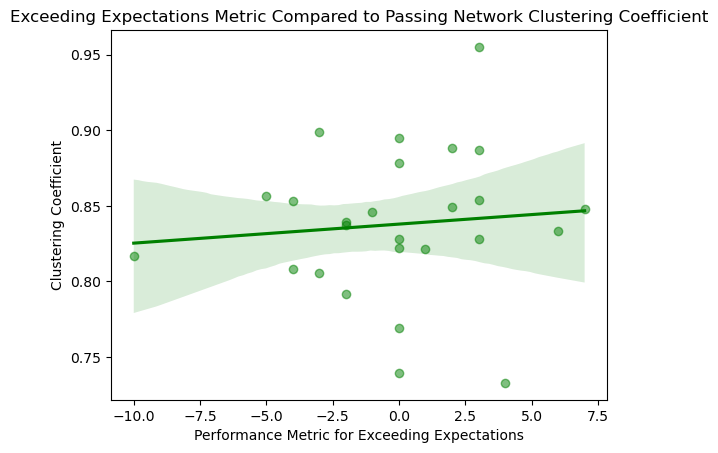

PearsonRResult(statistic=0.09468288079181632, pvalue=0.6454575826294673)

In [147]:
# visualizing the relationship between outperforming expectations and network clustering 

sns.regplot(x='RankingDifferential',
            y='ClusteringCoeff',
    data = nbassn2021_22,
           scatter_kws = {"color": "green", "alpha": 0.5},
            line_kws = {"color": "green"}) 
plt.xlabel('Performance Metric for Exceeding Expectations')
plt.ylabel('Clustering Coefficient')
plt.title('Exceeding Expectations Metric Compared to Passing Network Clustering Coefficient')
plt.show()

stats.pearsonr(nbassn2021_22['RankingDifferential'], nbassn2021_22['ClusteringCoeff'])

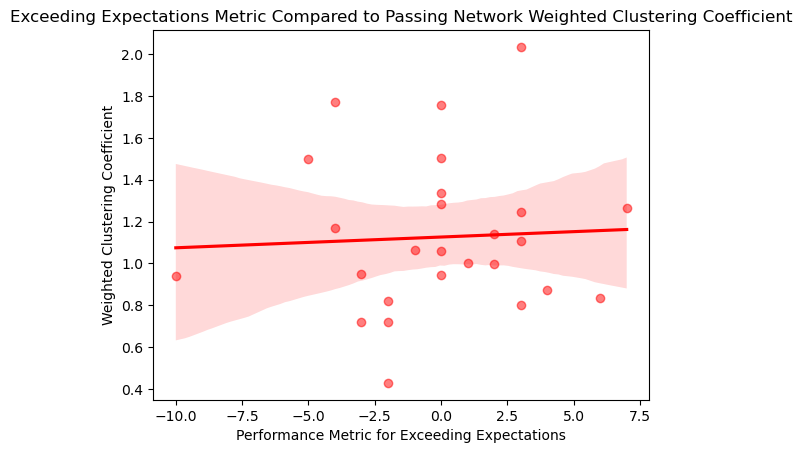

PearsonRResult(statistic=0.05150894303212679, pvalue=0.8026696611454752)

In [148]:
# visualizing the relationship between outperforming expectations and network clustering 

sns.regplot(x='RankingDifferential',
    y='WeightedClusteringCoeff',
    data = nbassn2021_22,
           scatter_kws = {"color": "red", "alpha": 0.5},
            line_kws = {"color": "red"}) 
plt.xlabel('Performance Metric for Exceeding Expectations')
plt.ylabel('Weighted Clustering Coefficient')
plt.title('Exceeding Expectations Metric Compared to Passing Network Weighted Clustering Coefficient')
plt.show()

stats.pearsonr(nbassn2021_22['RankingDifferential'], nbassn2021_22['WeightedClusteringCoeff'])


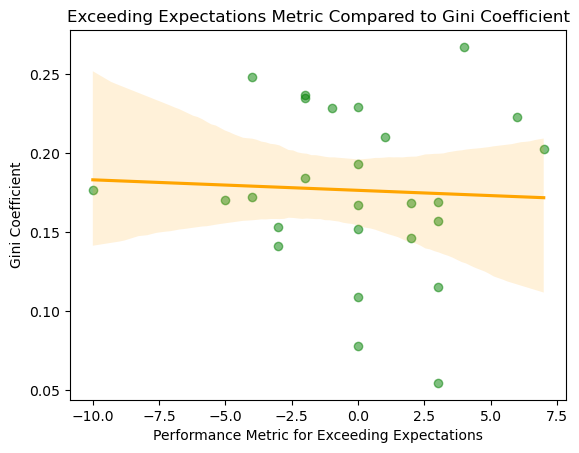

PearsonRResult(statistic=-0.047015623019598635, pvalue=0.8195925853601983)

In [273]:
# visualizing the relationship between outperforming expectations and Gini Coefficient

sns.regplot(x='RankingDifferential',
            y='GiniCoeff',
    data = nbassn2021_22,
           scatter_kws = {"color": "green", "alpha": 0.5},
            line_kws = {"color": "orange"}) 
plt.xlabel('Performance Metric for Exceeding Expectations')
plt.ylabel('Gini Coefficient')
plt.title('Exceeding Expectations Metric Compared to Gini Coefficient')
plt.show()

stats.pearsonr(nbassn2021_22['RankingDifferential'], nbassn2021_22['GiniCoeff'])

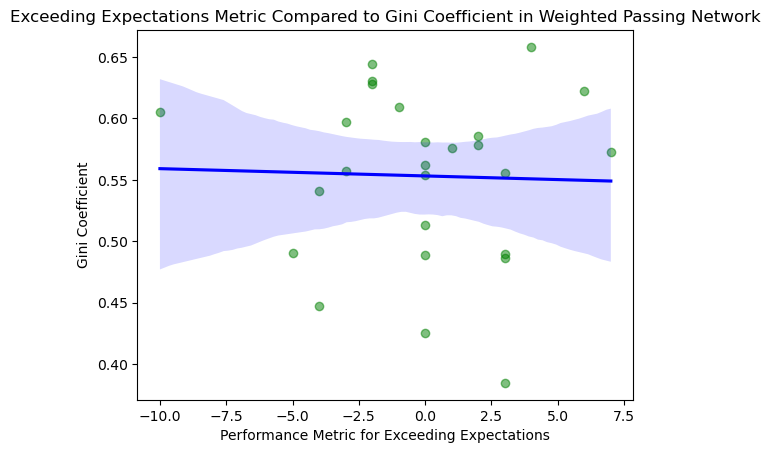

PearsonRResult(statistic=-0.031117996758832284, pvalue=0.8800515942164395)

In [274]:
# visualizing the relationship between outperforming expectations and Gini Coefficient for weighted network

sns.regplot(x='RankingDifferential',
            y='GiniCoeffWeighted',
    data = nbassn2021_22,
           scatter_kws = {"color": "green", "alpha": 0.5},
            line_kws = {"color": "blue"}) 
plt.xlabel('Performance Metric for Exceeding Expectations')
plt.ylabel('Gini Coefficient')
plt.title('Exceeding Expectations Metric Compared to Gini Coefficient in Weighted Passing Network')
plt.show()

stats.pearsonr(nbassn2021_22['RankingDifferential'], nbassn2021_22['GiniCoeffWeighted'])

In [275]:
final_results_df = nbassn2021_22[["TeamCity", "TeamName", "WINS", "TotalPasses", "TotalAsts",
                                  "RankingDifferential", "PlayoffRank",
                                 "PassesPerAssist", "ClusteringCoeff", "WeightedClusteringCoeff",
                                 "GiniCoeff", "GiniCoeffWeighted", "AllNbaHonors"]]
final_results_df.to_csv("nba_2021-22_results.csv") 
final_results_df.sort_values(by=["PlayoffRank", "WINS"], ascending = [True, False]).style.background_gradient(cmap='PuBuGn')


,TeamCity,TeamName,WINS,TotalPasses,TotalAsts,RankingDifferential,PlayoffRank,PassesPerAssist,ClusteringCoeff,WeightedClusteringCoeff,GiniCoeff,GiniCoeffWeighted,AllNbaHonors
1,Phoenix,Suns,64,21231,2217,1,1,9.576455,0.821714,1.000736,0.209914,0.576063,5
0,Miami,Heat,53,24247,2084,2,1,11.634837,0.849288,1.140825,0.146315,0.578178,2
3,Memphis,Grizzlies,56,22494,2098,7,2,10.721640,0.847913,1.262416,0.202807,0.572609,1
2,Boston,Celtics,51,23723,2012,4,2,11.790755,0.732821,0.871262,0.267090,0.658247,2
4,Golden State,Warriors,53,25127,2199,3,3,11.426558,0.955182,2.034394,0.054622,0.384545,2
5,Milwaukee,Bucks,51,20996,1958,-2,3,10.723187,0.837279,0.821513,0.236704,0.644227,3
7,Utah,Jazz,49,21813,1835,-2,5,11.887193,0.839206,0.721375,0.235010,0.630081,0
6,Toronto,Raptors,48,23072,1806,6,5,12.775194,0.833436,0.834516,0.222554,0.622192,2
9,Denver,Nuggets,48,25791,2274,-2,6,11.341689,0.791630,0.428624,0.184080,0.628347,3
8,Chicago,Bulls,46,22371,1957,2,6,11.431272,0.888584,0.996293,0.168127,0.585888,1


In [276]:
# Setting up a regression to measure predictor variable impact. 
import statsmodels.api as sm

X = final_results_df[['TotalPasses','TotalAsts','PassesPerAssist',
                      'ClusteringCoeff','WeightedClusteringCoeff',
                     "GiniCoeff", "GiniCoeffWeighted", "AllNbaHonors"]]  # dataframe with predictor variables

y = final_results_df['WINS'] 

X = sm.add_constant(X) # setting x intercept 

# fit the multivariate regression model
model = sm.OLS(y, X)  
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   WINS   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     4.202
Date:                Fri, 05 May 2023   Prob (F-statistic):            0.00618
Time:                        14:47:05   Log-Likelihood:                -86.254
No. Observations:                  26   AIC:                             190.5
Df Residuals:                      17   BIC:                             201.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

The multivariate regression attempts to predict wins based on the constructed attributes -- Total Passes, Total Assits, Passes per Assist, Clustering Coefficient, Weighted Clustering Coefficient, Gini Coefficient for the Unweighted Network, Gini Coefficient for the Weighted Network, and All-NBA Honors. The model produces a low R-squared value of 0.664.  Approximatelly 66% percent of the variability in end-of-season wins can be explained by the input variables. This value drops lower for the adjusted r-squared value indicating poor fit. The model has an F-statistic is 4.202 with a corresponding p-value of 0.0062, which is statistically significant at a conventional alpha level of 0.05. However, in this case, none of the coefficients are statistically significant as all the p-values are greater than alpha value. 